## Import functions and define universal values

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0,'./code')
import run_higher_sph_harm
import plot_utils
import colorcet as cc
import matplotlib.cm as cm


lcName='Put_Name_Here'
planetparams={}
planetparams['t0']=2955934.2922330229#units of days
planetparams['per']=0.813474061208349 #units of days
planetparams['a_abs']=0.01504 #units of AU
planetparams['inc']=82.282623113461 #units of degrees
planetparams['ecc']=0.0 #unitless
planetparams['w']=90. #units of degrees
planetparams['rprs']=0.157334359496779 #unitless ratio
planetparams['ars']=4.88289717045905 #unitless ratio
planetparams['Tstar']=4500. #units of K

#for if using a phase curve (since the transit will need to be removed)
planetparams['T14']= 3.7526/24   #units of days

#Change to True if using a phase curve
phasecurve = False

looking for spidermanrc file at /Users/briandavenport/.spidermanrc
no spidermanrc file detected


## Load in data and set up data dictionary

In [ ]:
homedir='HOMEDIR'

#Edit this block to account for the filetype and headers being used.
file=np.load(homedir+'FILEPATH')
time=file['time']
waves=file['wavelength']
err=file['error']

#Ensure flux is in ppm, where mid-ecplipse at 1e6
flux=file['flux']



#If this is a phase curve observation, remove transit, as that is not accounted for in models
if phasecurve == True:
    start = planetparams['t0'] - planetparams['T14']/2 - .01
    end = planetparams['t0'] + planetparams['T14']/2 + .01
    rows = []
    for i in range(len(time)):
        if time[i]>=start and time[i]<=end:
            rows.append(i)

    flux = np.delete(flux, rows)
    err = np.delete(err, rows)
    time = np.delete(time, rows)



extent=np.zeros(2)
extent[0]=(np.min(time)-planetparams['t0'])/planetparams['per']*2.*np.pi-np.pi/2.-np.pi #minimum observed point, in radians
extent[1]=(np.max(time)-planetparams['t0'])/planetparams['per']*2.*np.pi+np.pi/2.-np.pi #maximum observed point, in radians


plt.figure()
plt.errorbar(time,flux,yerr=err,color='k',marker='.',linestyle='none')
plt.show()
datadict={'time (days)':time, 'wavelength (um)': waves, 'flux (ppm)': flux, 'flux err (ppm)': err}

## Perform Prefitting Routine

In [ ]:
#Skip this cell if already completed
ordmin=3
ordmax=6
eigenmin=2
eigenmax=6
BICdict=eigencurves_prefit.eigencurves(datadict,planetparams,homedir,ordmin,ordmax,eigenmin,eigenmax,\
                            lcName=lcName,plot=True,strict=False,nonegs=True,verbose=True)

In [4]:
#Import optimal spherical harmonic orders and number of eigencurves from prefit
prefit_path = homedir+'/data/besteigenlists/'+lcName+'/'

prefit_file = np.load(prefit_path+'prefit.npz', encoding='latin1',allow_pickle=True)

subsection = prefit_file['arr_0'].tolist()

norder = subsection['best fit degree'].astype(int).tolist()
ncurves = subsection['best fit num eigencurves'].astype(int).tolist()

## Perform eigencurve fitting at each wavelength

In [5]:
saveDir = homedir+"/data/sph_harmonic_coefficients_full_samples/" + lcName

run_higher_sph_harm.run_lc_fit(datadict,planetparams,norder=norder\
                                    ,lcName=lcName,\
                                    saveDir=saveDir,firstfits=prefit_path,afew=ncurves,\
                                    burnin=3500,nsteps=35000,plot=True,strict=False,nonegs=True)

Found the previously-run file /Users/briandavenport/JWST/EclipseMapping//data/sph_harmonic_coefficients_full_samples/W43_spectroscopic_phasecurve/spherearray_deg_list.npz. Now exiting


## Plot 2D maps: Convert from spherical harmonics to maps

In [7]:
#Kept this in but not sure what this is used for

f=np.load(homedir+'/data/sph_harmonic_coefficients_full_samples/'+lcName+'/spherearray_deg_list.npz',allow_pickle=True)
outDictionary=f['arr_0'].tolist()
eigensamples=outDictionary['eigencurve coefficients']
vals=np.zeros(len(eigensamples))
for i in np.arange(len(eigensamples)):
    vals[i]=np.shape(eigensamples[i])[0]
numsamp=np.min(vals)
print(vals)

[12500. 40900. 47300. 33000.  9000.  8400. 95700. 95700.  6500.  6600.
 47300.]


In [8]:
dataDir=saveDir+'/'
outputDir=homedir+'/data/normalized_maps/'+lcName+'/flux_maps/'

londim=40 #360 is one point per degree 120 40
latdim=20 #180 is one point per degree 60 20

outputpath = plot_utils.retrieve_map_full_samples\
    (planetparams,dataDir,outputDir,londim,latdim,afew=ncurves,degree=norder,nrandom='all',isspider=False)

Found the previously saved file /Users/briandavenport/JWST/EclipseMapping//data/normalized_maps/W43_spectroscopic_phasecurve/flux_maps/wave_5.25. Now exiting.
Found the previously saved file /Users/briandavenport/JWST/EclipseMapping//data/normalized_maps/W43_spectroscopic_phasecurve/flux_maps/wave_5.75. Now exiting.
Found the previously saved file /Users/briandavenport/JWST/EclipseMapping//data/normalized_maps/W43_spectroscopic_phasecurve/flux_maps/wave_6.25. Now exiting.
Found the previously saved file /Users/briandavenport/JWST/EclipseMapping//data/normalized_maps/W43_spectroscopic_phasecurve/flux_maps/wave_6.75. Now exiting.
Found the previously saved file /Users/briandavenport/JWST/EclipseMapping//data/normalized_maps/W43_spectroscopic_phasecurve/flux_maps/wave_7.25. Now exiting.
Found the previously saved file /Users/briandavenport/JWST/EclipseMapping//data/normalized_maps/W43_spectroscopic_phasecurve/flux_maps/wave_7.75. Now exiting.
Found the previously saved file /Users/brianda

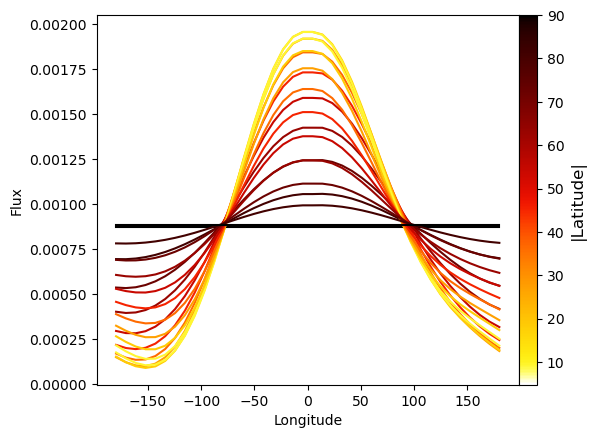

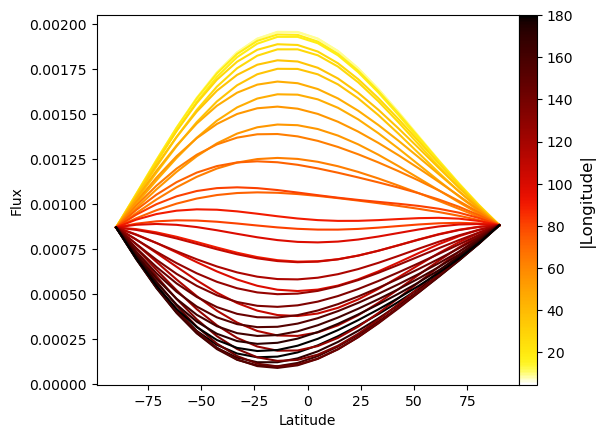

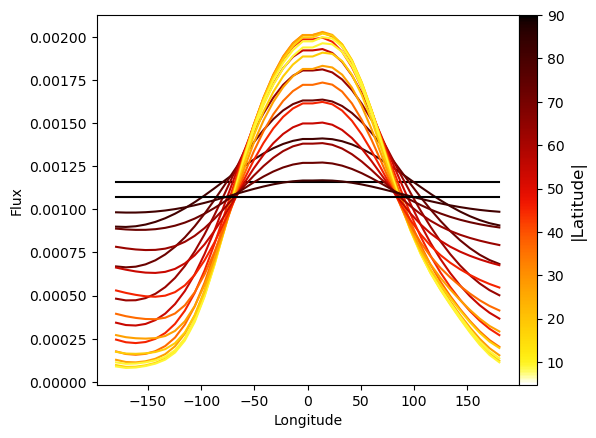

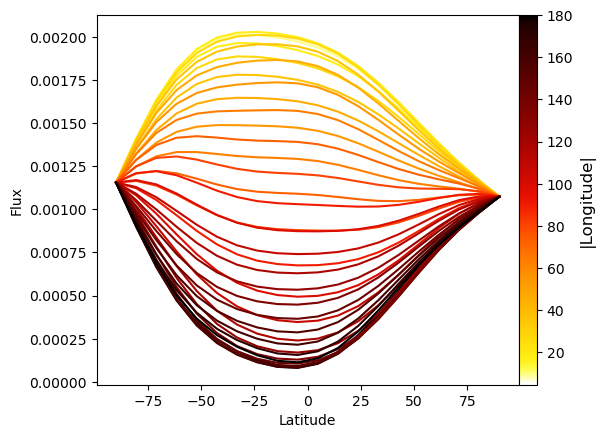

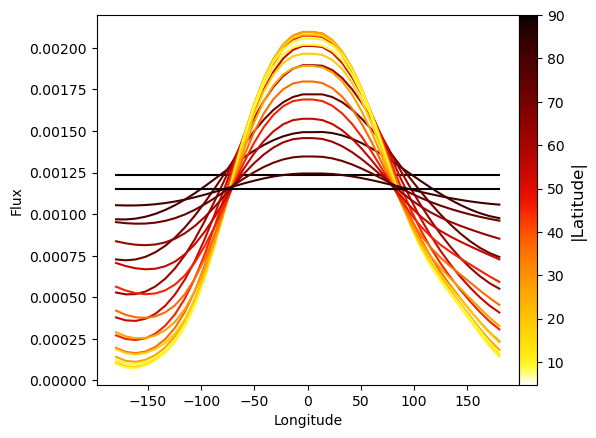

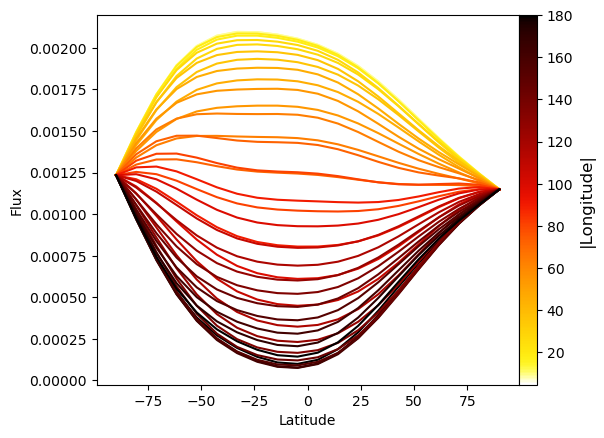

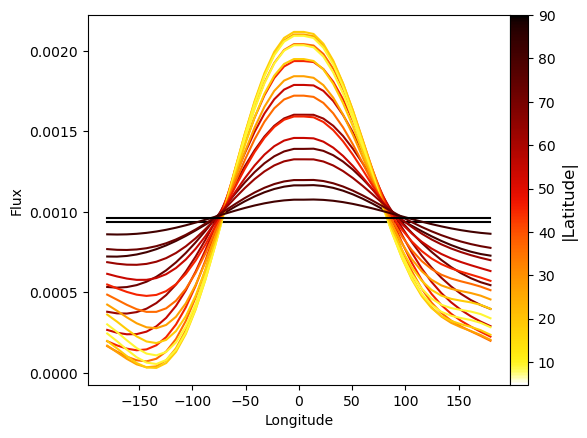

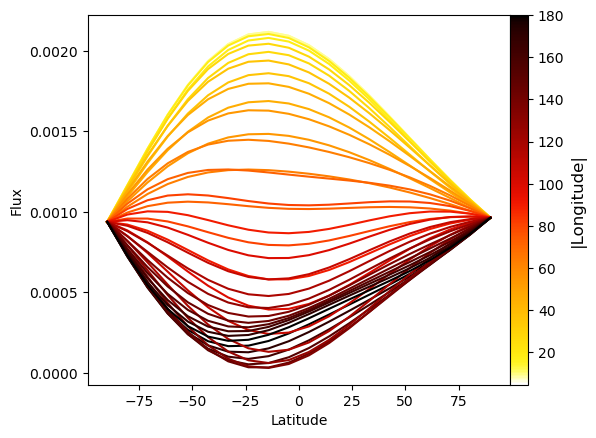

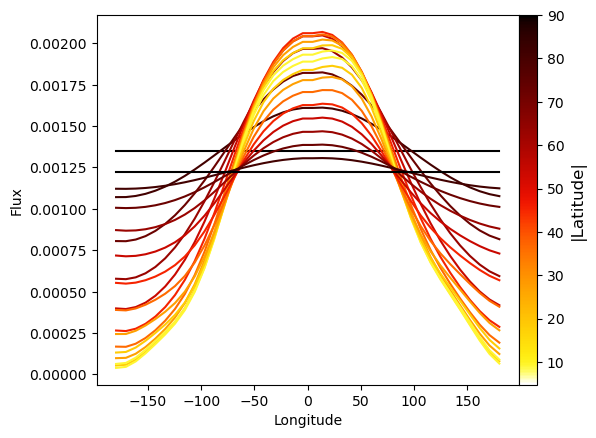

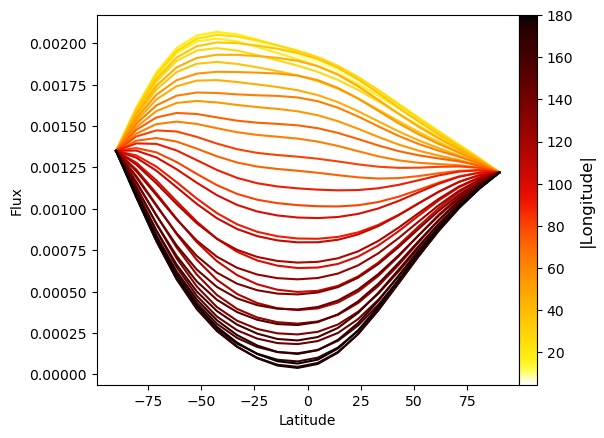

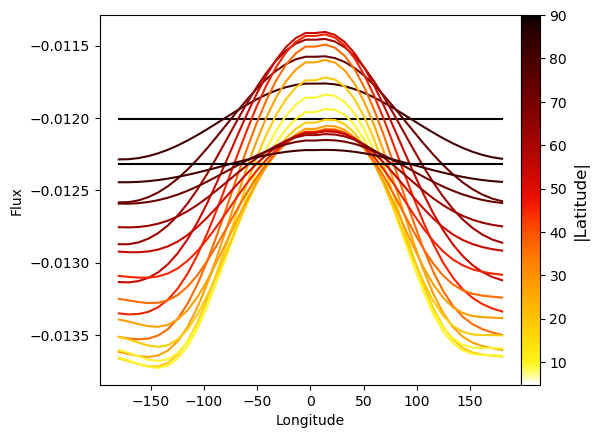

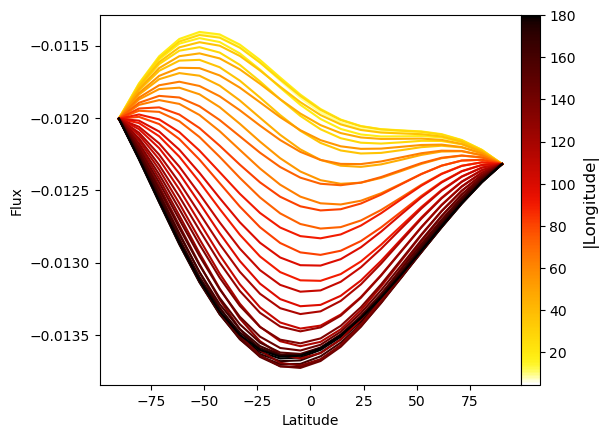

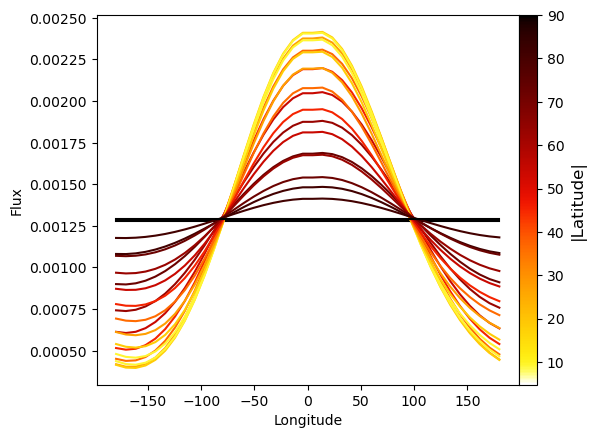

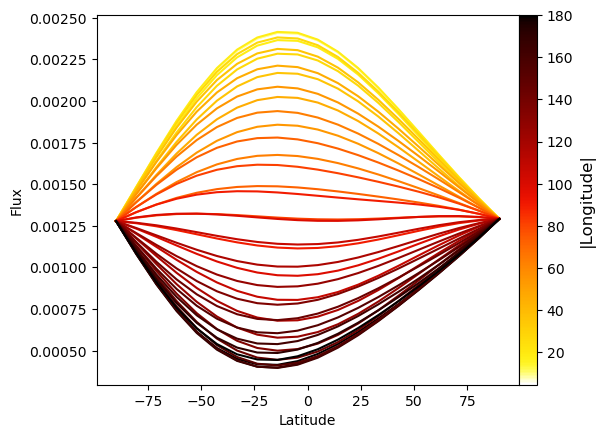

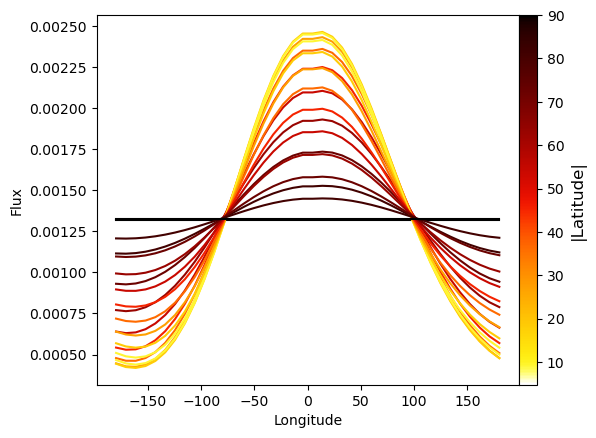

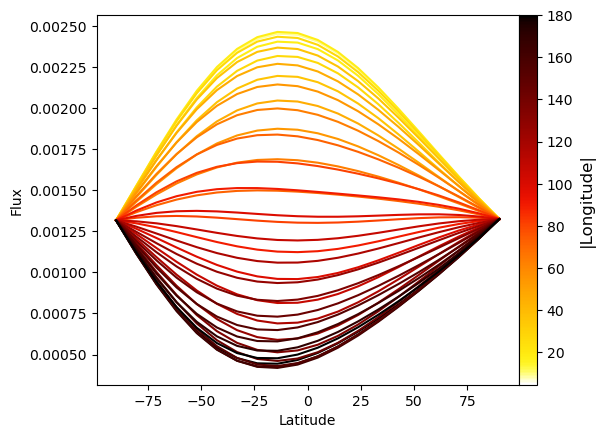

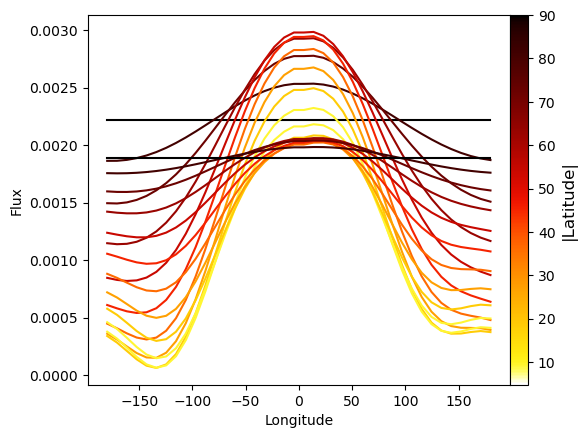

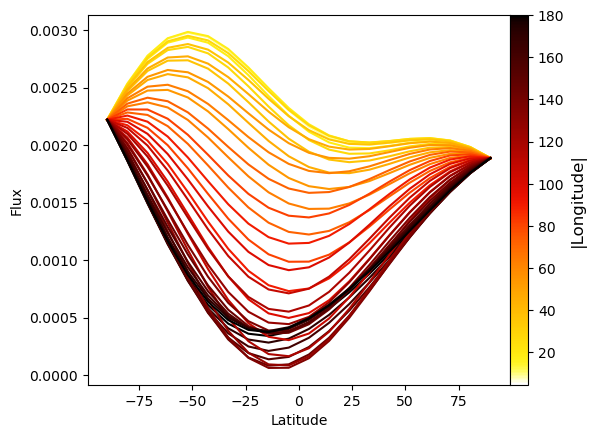

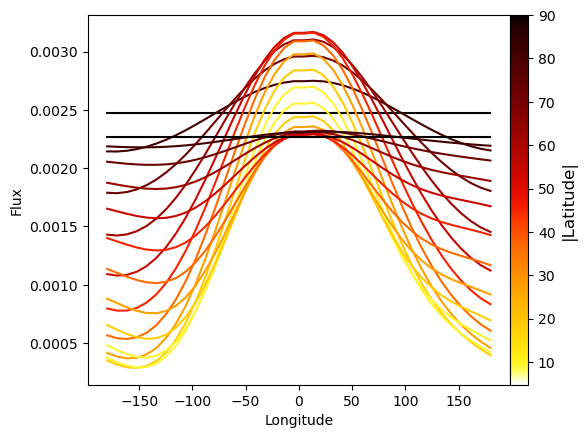

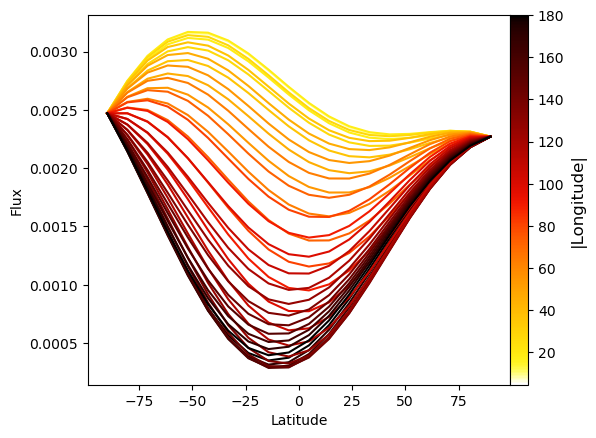

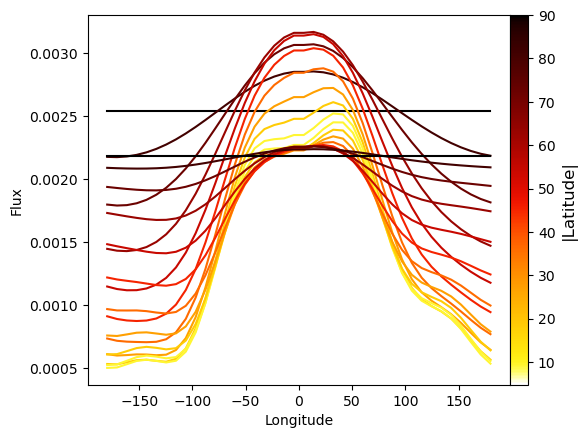

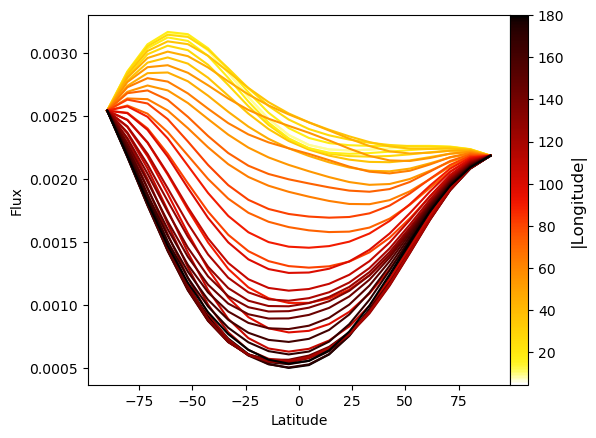

In [9]:
#Quick plots of flux w/ longitude and latitude for visualization and for troubleshooting without
#having to wait for the full 2D Flux maps to build

minflux_perbin = []
maxflux_perbin = []

for k in waves:
    map_files = np.load(homedir+'/data/normalized_maps/'+lcName+f'/flux_maps/wave_{k}.npz')
    wavelength = map_files['arr_0']
    lat = map_files['arr_1']
    lons = map_files['arr_2']
    flux_map = map_files['arr_3']
    
    #calculate min and max flux for wavelength bin
    minflux_perbin.append(np.min(flux_map))
    maxflux_perbin.append(np.max(flux_map))
    
    #colorbar for latitude
    lat_norm = (abs(lat[:,0])*180./np.pi)/90.
    col_lat = cc.cm.fire_r(lat_norm)

    lon_norm = (abs(lons[0,:])*180./np.pi)/180.
    col_lon = cc.cm.fire_r(lon_norm)


    max_lons_i = []
    for i in range(latdim):
        plt.plot(lons[i]*180/np.pi, flux_map[i], color=col_lat[i])
        max_lons_i.append(np.argmax(flux_map[i]))
    plt.xlabel('Longitude')
    plt.ylabel('Flux')
    im = plt.scatter(lons[:,0]*180/np.pi, flux_map[:,0], s=0, cmap=cc.cm.fire_r, c=(abs(lat[:,0])*180./np.pi))
    cbar = plt.colorbar(im, pad=0)
    cbar.set_label(label='|Latitude|', size=12)
    plt.savefig(homedir + '/data/normalized_maps/'+lcName+f'/flux_maps/Flux_vs_Longitude_{k}.png')

    plt.show()

    max_lats_i = []
    for j in range(londim):
        plt.plot(lat[:,j]*180/np.pi, flux_map[:,j], color=col_lon[j])
        max_lats_i.append(np.argmax(flux_map[:,j]))

    plt.xlabel('Latitude')
    plt.ylabel('Flux')
    im = plt.scatter(lat[0,:]*180/np.pi, flux_map[0,:], s=0, cmap=cc.cm.fire_r, c=(abs(lons[0,:])*180./np.pi))
    cbar = plt.colorbar(im, pad=0)
    cbar.set_label(label='|Longitude|', size=12)
    plt.savefig(homedir + '/data/normalized_maps/'+lcName+f'/flux_maps/Flux_vs_Latitude_{k}.png')
    plt.show()

## Plot 2D Maps: Perform Plotting

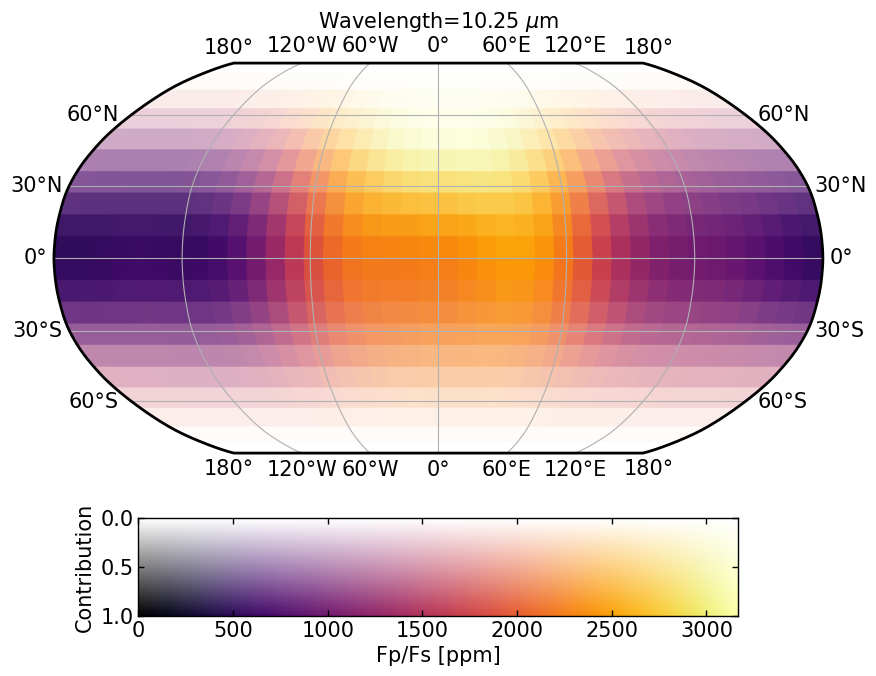

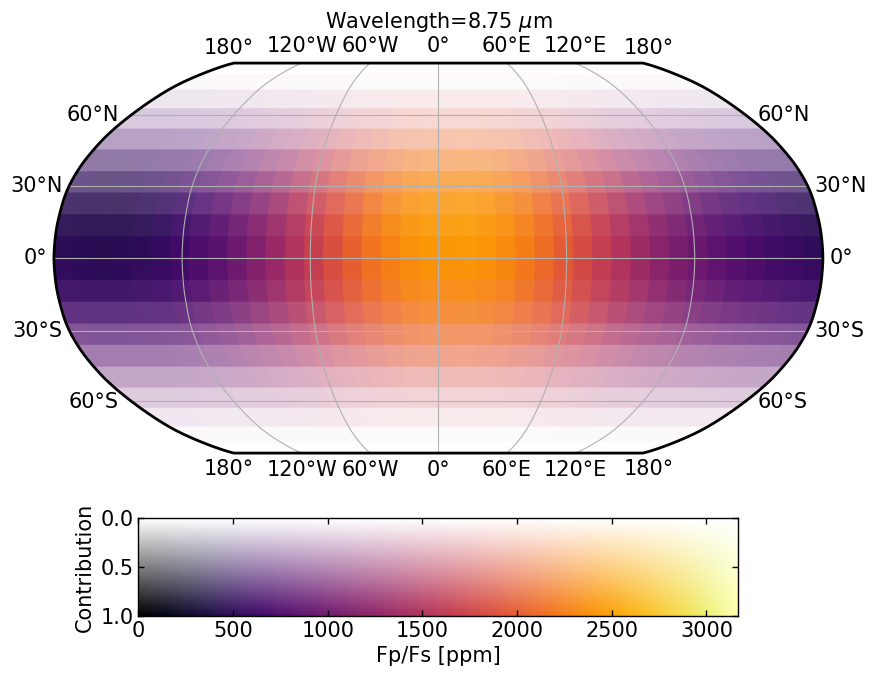

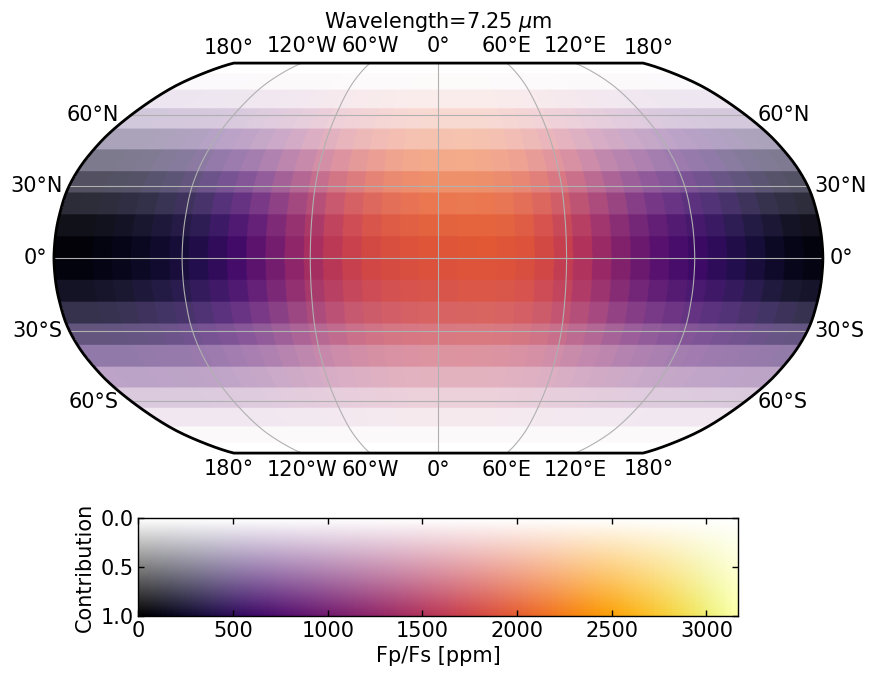

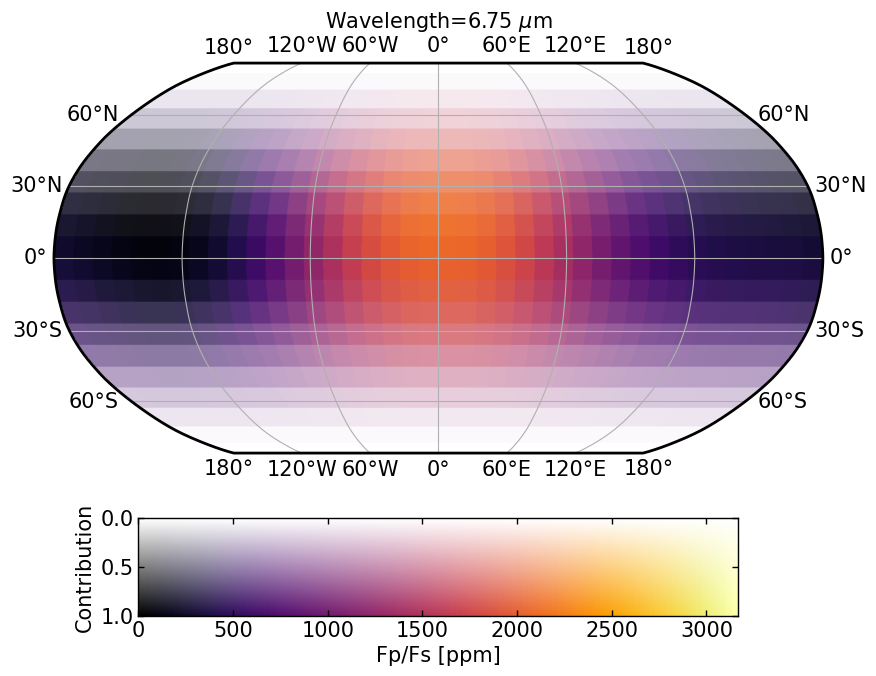

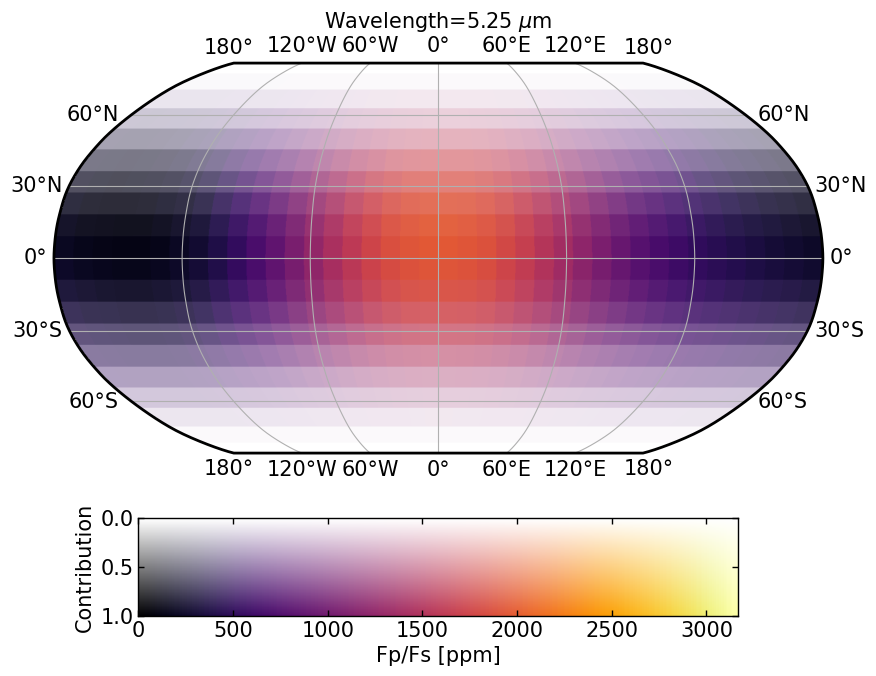

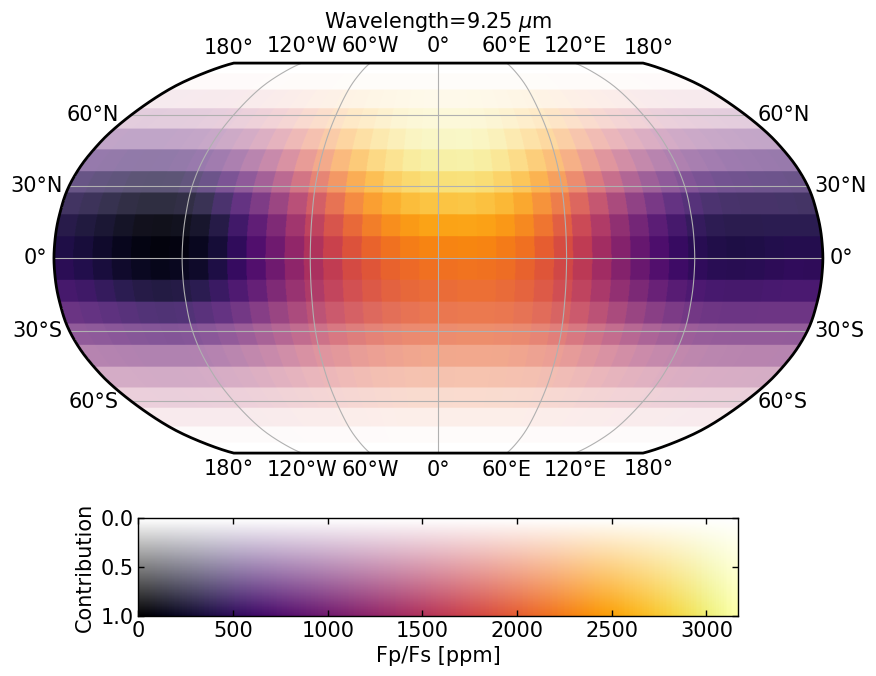

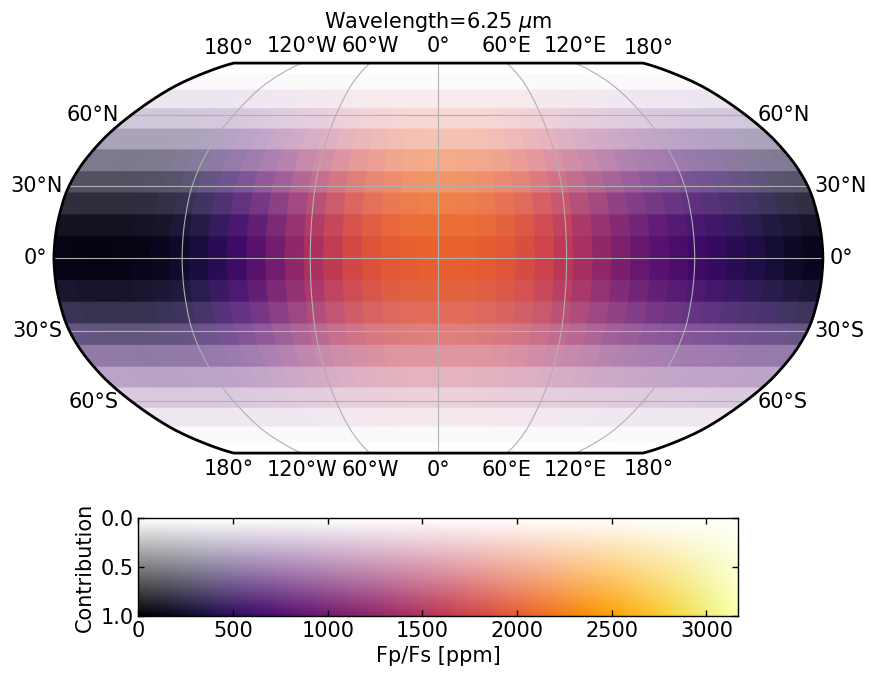

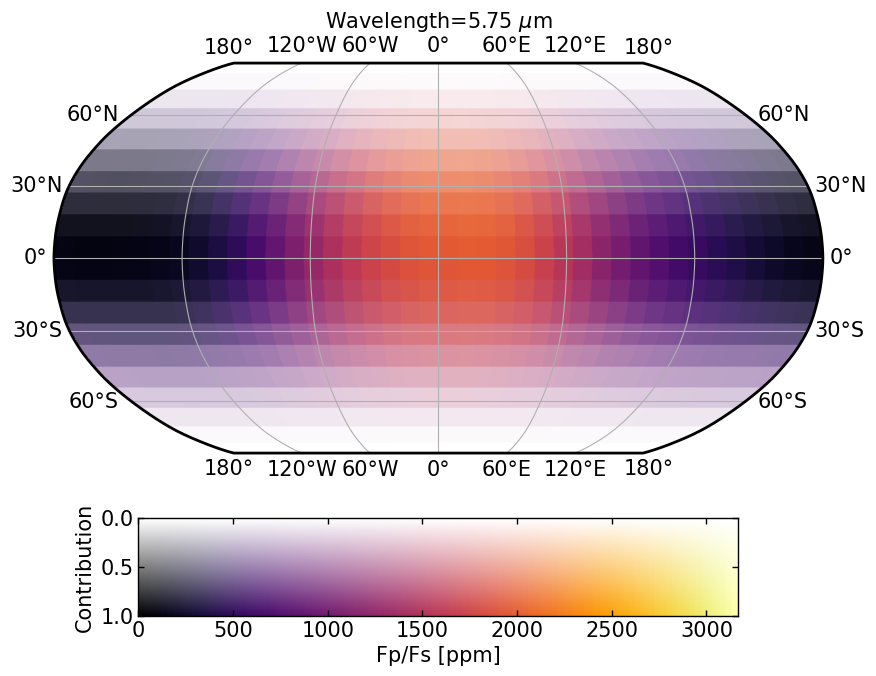

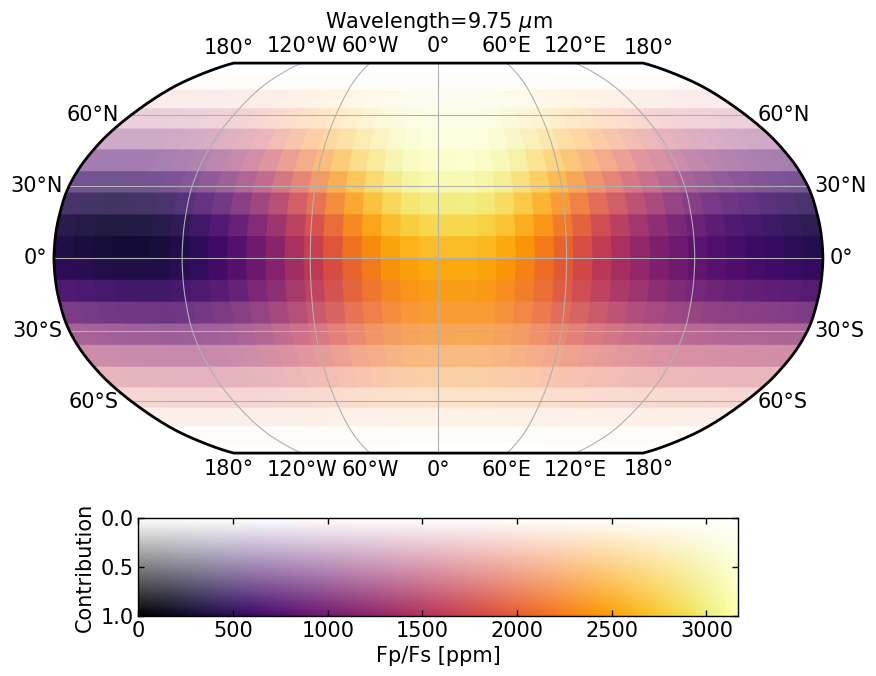

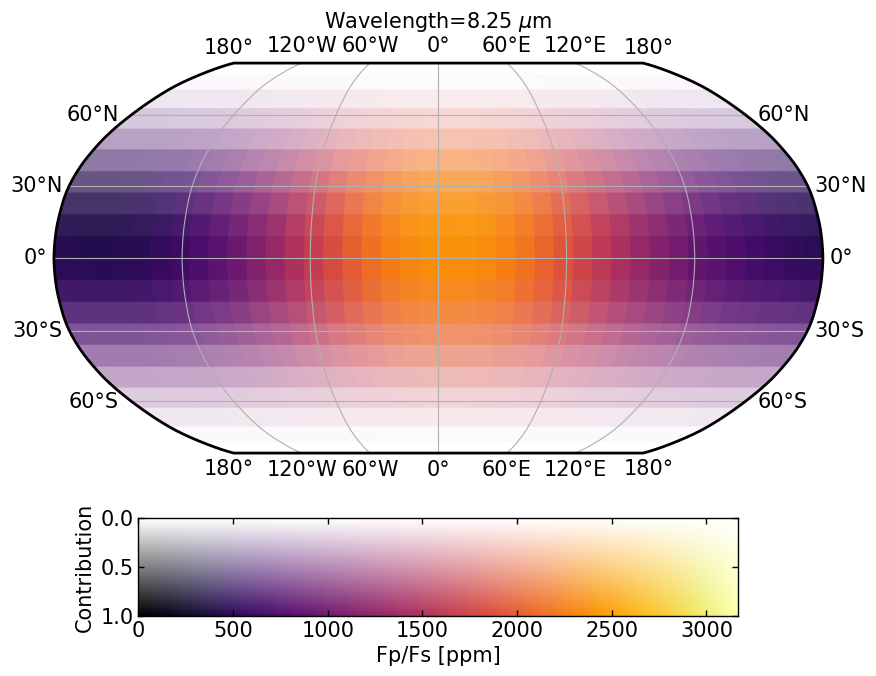

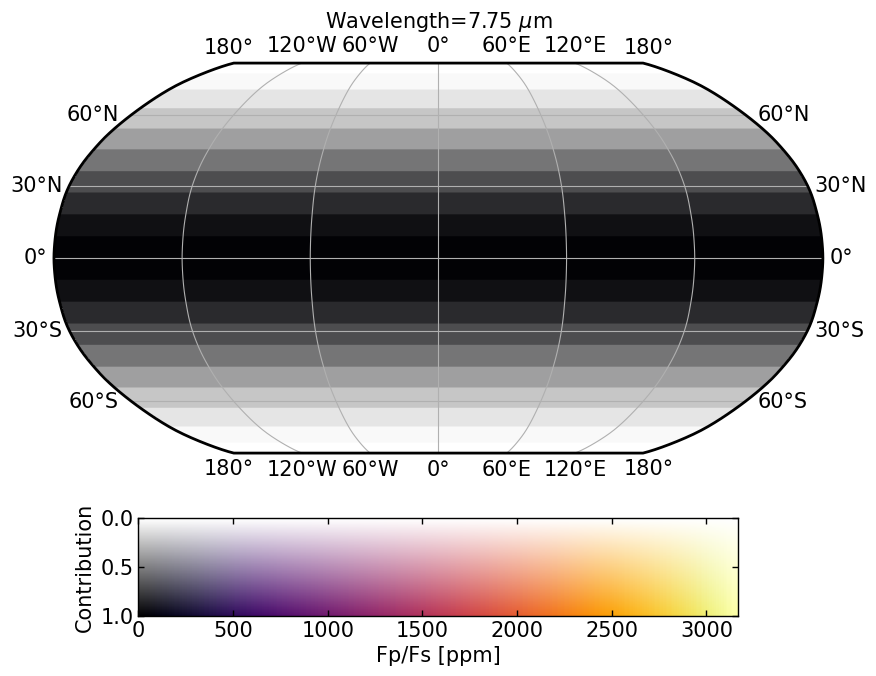

In [10]:
outputpath=homedir+'/data/normalized_maps/'+lcName+'/flux_maps/'

minflux = np.min(minflux_perbin)
maxflux = np.max(maxflux_perbin)
if minflux<0.:
    minflux=0.

mapLowMedHigh = plot_utils.plot_retrieved_map(outputpath,waves,extent,minflux,maxflux,waveInd='Full',\
                                                          saveName=lcName)

In [6]:
##get throughput
from pandeia.engine.instrument_factory import InstrumentFactory
import numpy as np
import matplotlib.pyplot as plt


#for wasp-43 MIRI
conf={"detector": {"nexp": 1,"ngroup": 64,"nint": 1,"readout_pattern": "fastr1","subarray": "full"},
    "dynamic_scene": False,"instrument": {"disperser": "p750l", "instrument": "miri","mode": "lrsslitless"},}


instrument_factory = InstrumentFactory(config=conf)
wavelengths=np.linspace(4.5,12.5,100000)
throughput=instrument_factory.get_total_eff(wavelengths)

through_arr = np.column_stack((wavelengths, throughput))
np.savetxt('miri_lrs.txt', through_arr)

plt.figure()
plt.plot(wavelengths,throughput)
plt.show()

ModuleNotFoundError: No module named 'pandeia'

In [ ]:
Tstar=planetparams['Tstar']
rprs=planetparams['rprs']
savepath=homedir+'/data/normalized_maps/'+lcName+'/temp_maps/'
datadir=homedir+'/data/normalized_maps/'+lcName'/flux_maps/'
#if reading in a model, the wavelengths must be in units of m and the flux must be in units of W/m^3/sr
# smodel=np.loadtxt('./PHOENIX_W18_Teff_6435K_logg_4.35_corrunit.txt')
#use smodel=smodel if using phoenix model

test=plot_utils.plot_map_in_temp(datadir,savepath,waves,dlam,rprs,extent,waveInd='Full',\
                                         saveName=lcName,startype='Temp',Tstar=Tstar,smodel=None)


Step 0


## Calculate brightest point in longitude and latitude

(4, 19)
-4.61538461538462


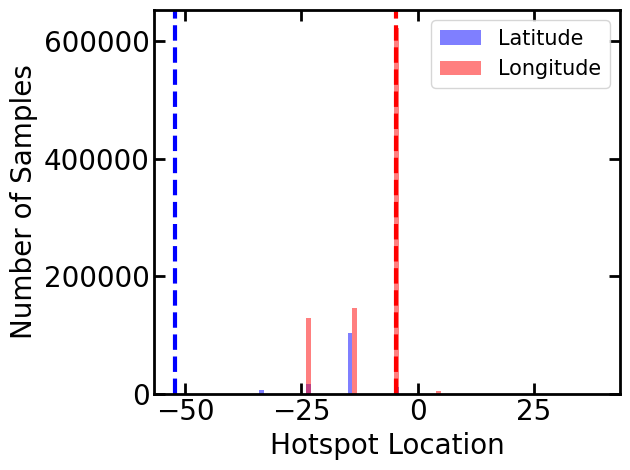

In [5]:
outputpath=homedir+'/data/normalized_maps/'+lcName+'/flux_maps/'
min_lon=-40
max_lon=40
step_size=1
hotlats,hotlons = plot_utils.find_hotspot(outputpath,waves,min_lon,max_lon,step_size,waveInd='Full',\
                                                  saveName=lcName)


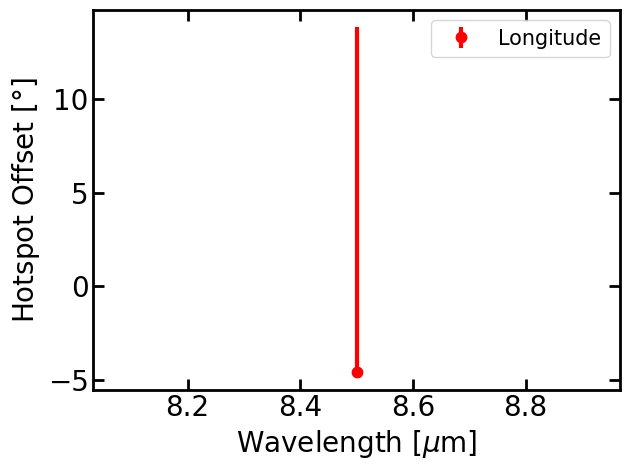

[-4.61538462]


In [6]:
from matplotlib import rc
rc('axes',linewidth=2)
plt.figure()
# plt.errorbar(waves,hotlats[:,1],yerr=[(hotlats[:,1]-hotlats[:,0]),(hotlats[:,2]-hotlats[:,1])],color='b',\
             #label='Latitude',marker='.',linestyle='none',markersize=15,linewidth=3)
plt.errorbar(waves,hotlons[:,2],yerr=[(hotlons[:,4]-hotlons[:,2]),(hotlons[:,2]-hotlons[:,0])],color='r',\
             label='Longitude',marker='.',linestyle='none',markersize=15,linewidth=3)
plt.tick_params(labelsize=20,axis="both",top=True,right=True,width=2,length=8,direction='in')
plt.legend(fontsize=15)
plt.xlabel('Wavelength [$\mu$m]',fontsize=20)
plt.ylabel('Hotspot Offset [$\degree$]',fontsize=20)
plt.tight_layout()
plt.savefig(outputpath+'hotspot_offset_longonly.pdf')
plt.show()
print(hotlons[:,2])
# newfile=open('hotspot_offset_bin25.txt','w')
# for i in np.arange(len(waves)):
#     print(waves[i],hotlons[i,0],hotlons[i,1],hotlons[i,2],hotlons[i,3],hotlons[i,4],file=newfile)
# newfile.close()

## Perform grouping

python(96895) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Step 0
3.2539420127868652
Step 100
0.27944183349609375
Step 200
0.19252300262451172
Step 300
0.21788525581359863
Step 400
0.19802188873291016
Step 500
0.2100379467010498
0.33665338645418325 0.6533864541832669


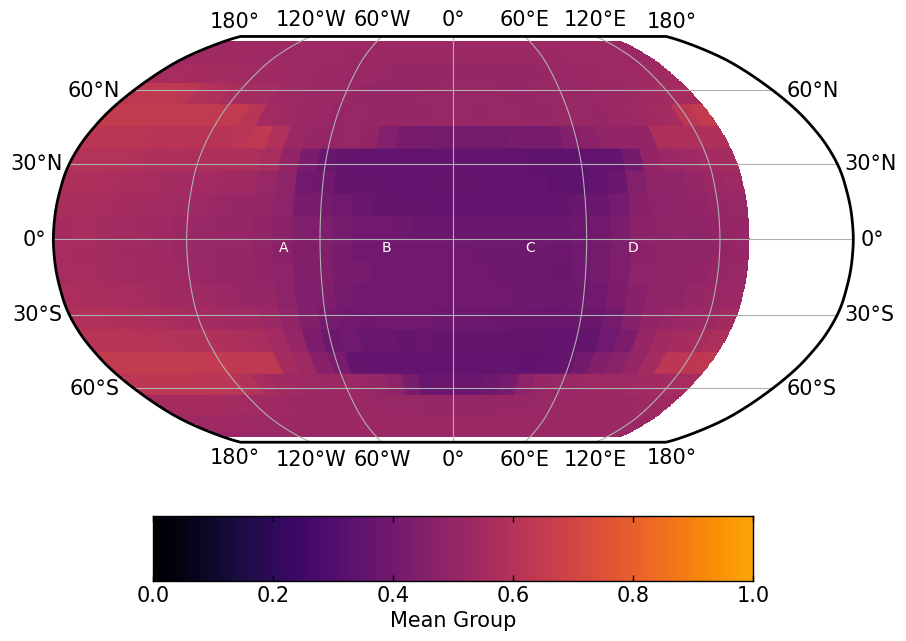

Percentage in Maximum Group, point 0: 52.39043824701195
Percentage in Maximum Group, point 1: 60.756972111553786
Percentage in Maximum Group, point 2: 62.94820717131474
Percentage in Maximum Group, point 3: 56.97211155378486


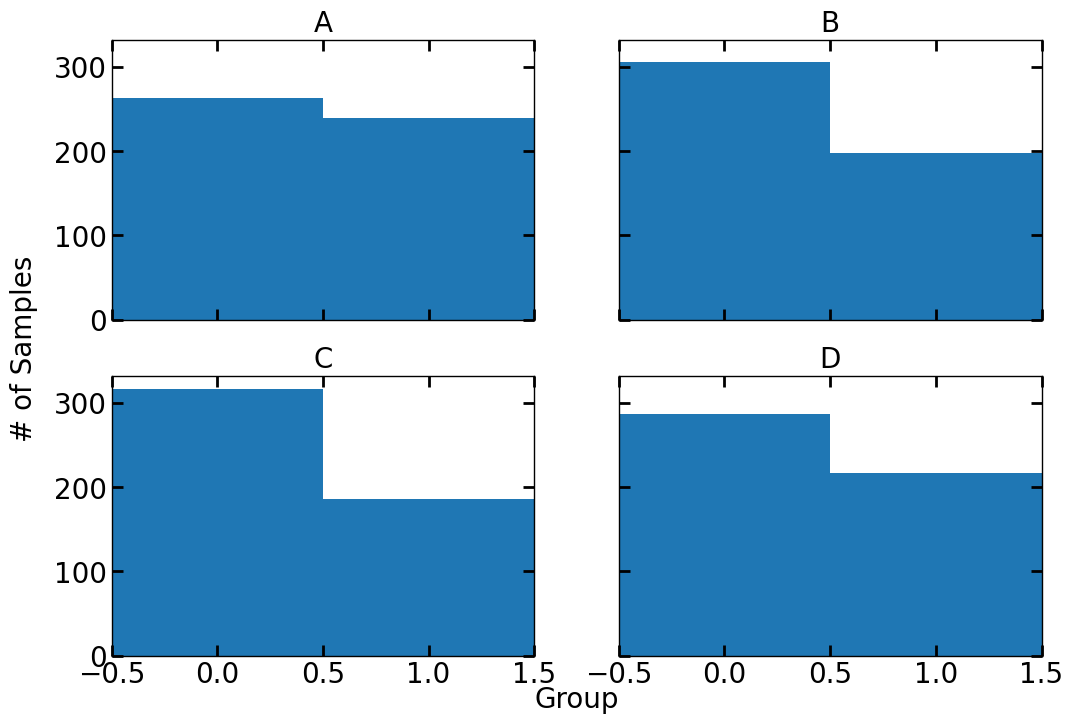

ValueError: 'x' and 'y' must have the same size

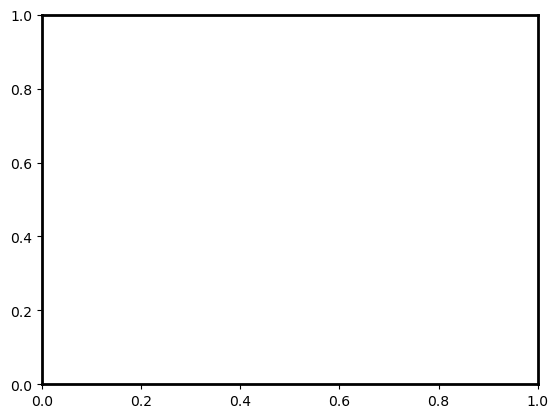

In [3]:
dataDir=homedir+'/data/normalized_maps/W43_spectroscopic_phasecurve/flux_maps/'
ngroups=2 #FINDME: change ngroups to cluster the data into a different number of eigengroups
#If the kernel dies, use a smaller number of samples.
numsamp=502
waves = np.array([5.25, 5.75, 6.25, 6.75, 7.25, 8.25, 8.75])
eigenspec,eigenerr,grouping,fullplanetspec,fullplaneterr = plot_utils.find_groups(dataDir,waves,\
                            extent,numsamp,ngroups=ngroups,letters=True)
#FINDME: can change trySamples to set the number of MCMC draws you'd like to use to find the groups (larger number will make it run slower)

/Users/briandavenport/opt/anaconda3/envs/eigenspectra/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 400.
  warnings.warn(errors[info][0], RuntimeWarning)


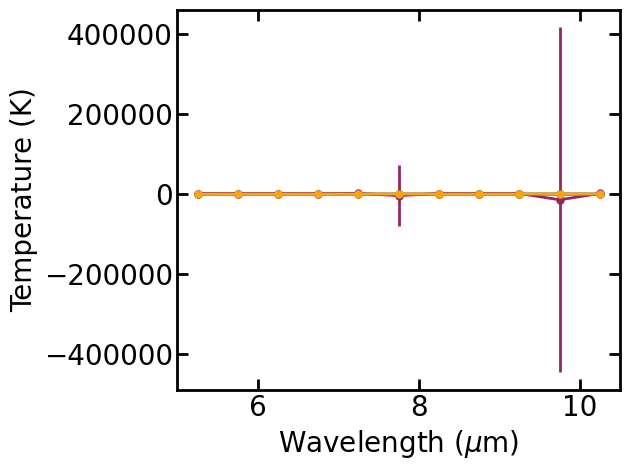

In [4]:
#convert eigenspectra to temperatures
dataDir=homedir+'/data/normalized_maps/W43_spectroscopic_phasecurve/flux_maps/'
ngroups=3 #FINDME: change ngroups to cluster the data into a different number of eigengroups
#If the kernel dies, use a smaller number of samples.
numsamp=500
rprs=planetparams['rprs']
# smodel=np.loadtxt('./PHOENIX_W18_Teff_6435K_logg_4.35_corrunit.txt')
Tstar=4500.
tempspec,temperr=plot_utils.group_spectra_in_temp(dataDir,numsamp,ngroups,dlam,rprs,startype='Temp',Tstar=Tstar,smodel=None)



In [14]:
print(tempspec)
print(waves)
print(np.shape(tempspec))
print(np.shape(temperr))
# print(fullplanetspec,fullplaneterr)
newfile=open('temp_spec_11bins_3groups.txt','w')
# for i in np.arange(np.shape(waves)[0]):
#     print(waves[i],tempspec[0,i],temperr[0,i,0],temperr[0,i,1],tempspec[1,i],temperr[1,i,0],temperr[1,i,1],\
#           tempspec[2,i],temperr[2,i,0],temperr[2,i,1],tempspec[3,i],temperr[3,i,0],temperr[3,i,1],file=newfile)
for i in np.arange(np.shape(waves)[0]):
    print(waves[i],tempspec[0,i],temperr[0,i,0],temperr[0,i,1],tempspec[1,i],temperr[1,i,0],temperr[1,i,1],\
          tempspec[2,i],temperr[2,i,0],temperr[2,i,1],file=newfile)
newfile.close()

[[ 1.28092716e+01  1.17462144e+01  1.08448236e+01  1.00732989e+01
   9.40273603e+00  8.81587901e+00  8.29614804e+00  7.83602133e+00
   7.42384590e+00  7.05206497e+00  6.71909563e+00]
 [ 1.40705915e+03  1.33523188e+03  1.33078788e+03  1.21873749e+03
   1.58536644e+03 -3.98324455e+03  1.34129389e+03  1.33511353e+03
   1.31346860e+03 -1.43259683e+04  1.43505458e+03]
 [ 1.28092716e+01  1.17462144e+01  1.08448236e+01  1.00732989e+01
   9.40273603e+00  8.81587901e+00  8.29614804e+00  7.83602133e+00
   7.42384590e+00  7.05206497e+00  6.71909563e+00]]
[ 5.25  5.75  6.25  6.75  7.25  7.75  8.25  8.75  9.25  9.75 10.25]
(3, 11)
(3, 11, 2)


/Users/briandavenport/eigenspectra/./code/plot_utils.py:1430: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  astuff = a.imshow(colorbardata, aspect='auto',extent=cbarextent,interpolation='none')


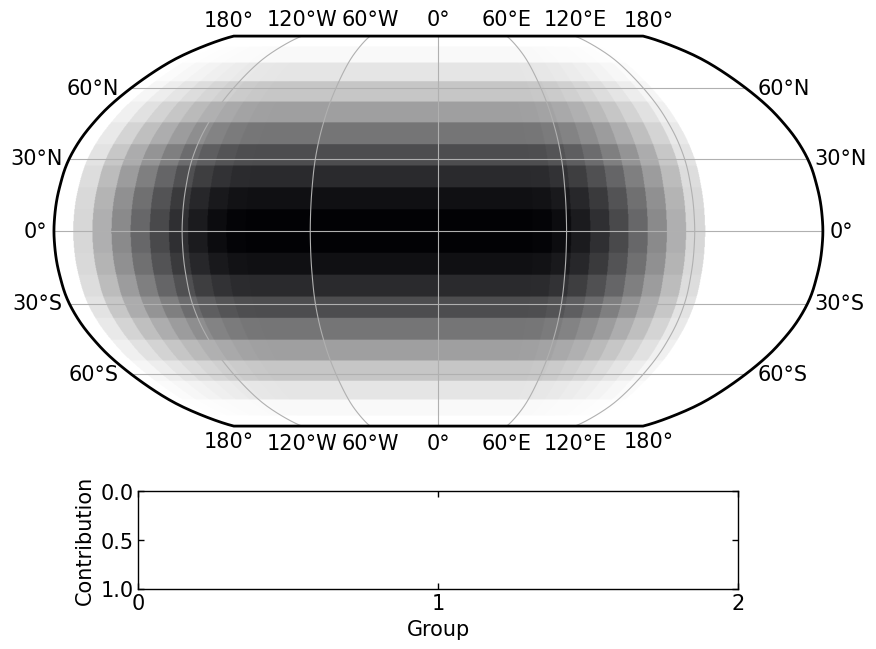

In [16]:
savedir=homedir+'/data/normalized_maps/W43_spectroscopic_phasecurve/flux_maps/'
ngroups=3
numsamp=500
plot_utils.do_hue_maps(savedir,numsamp,ngroups,hueType='group')



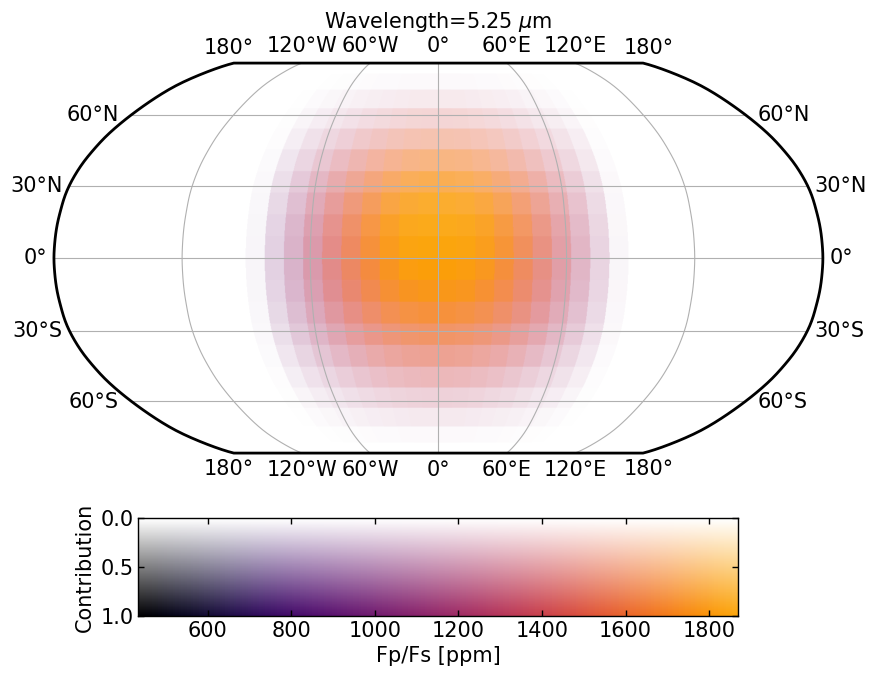

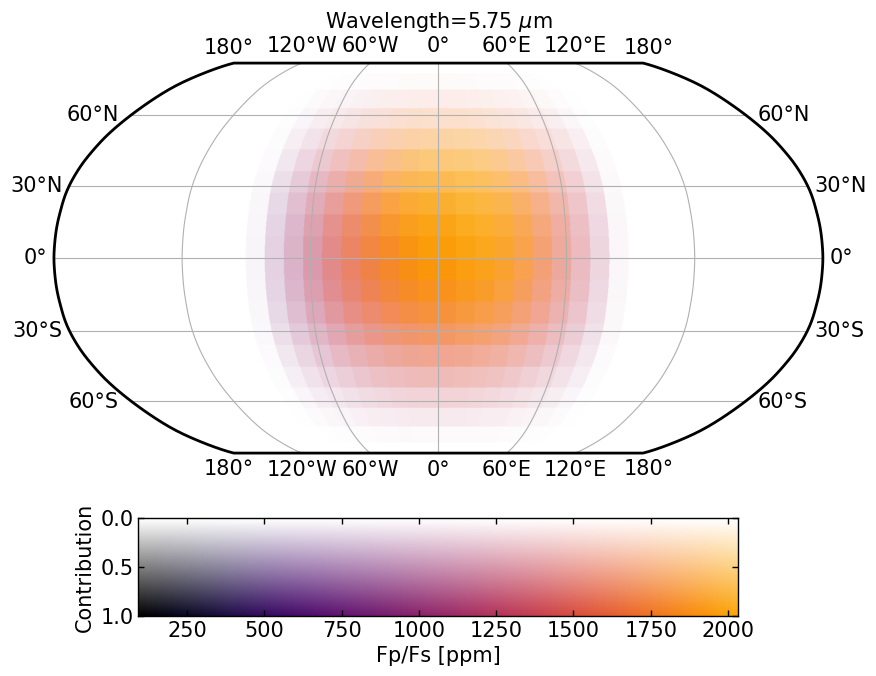

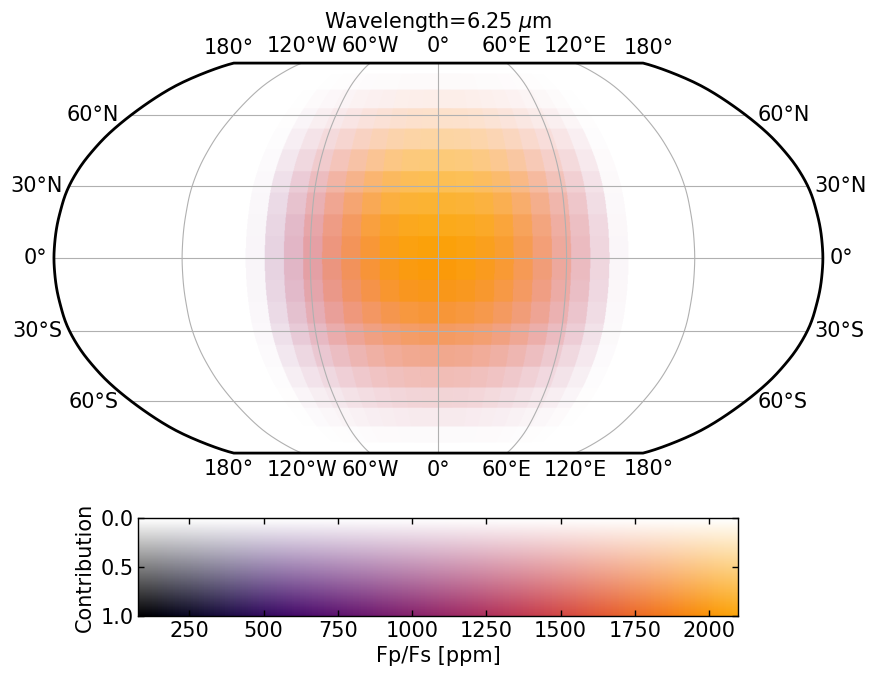

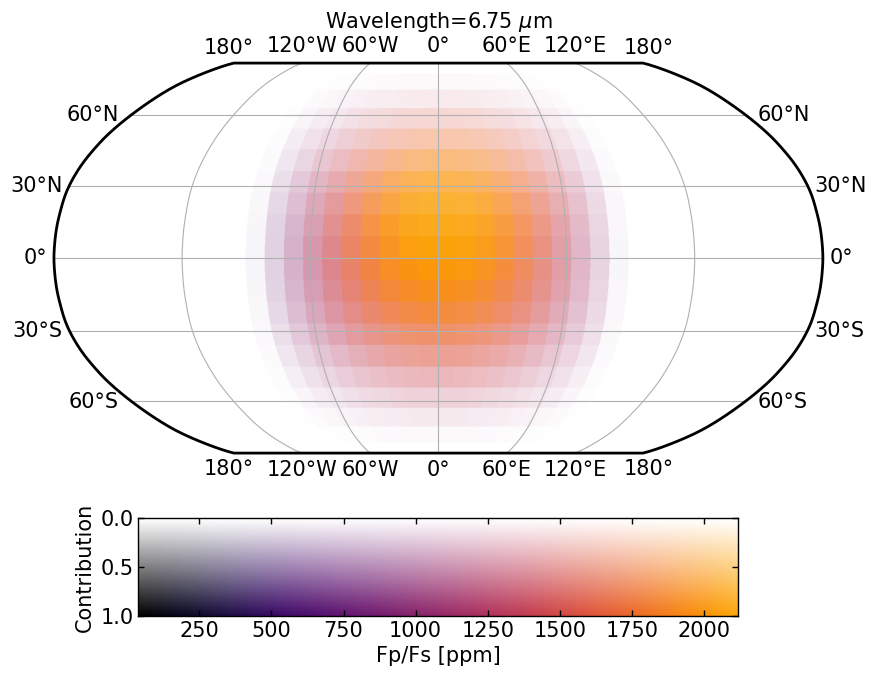

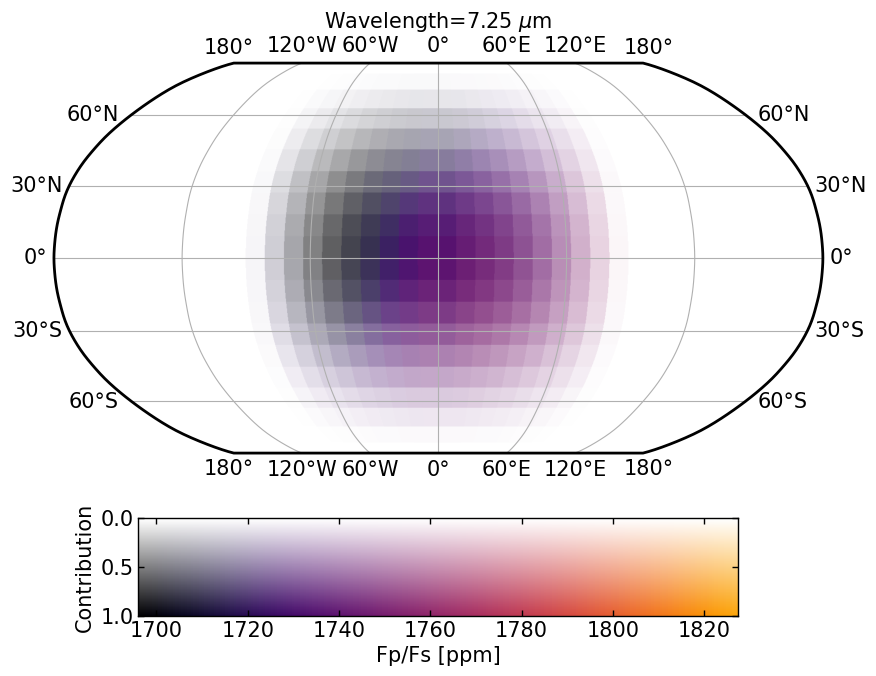

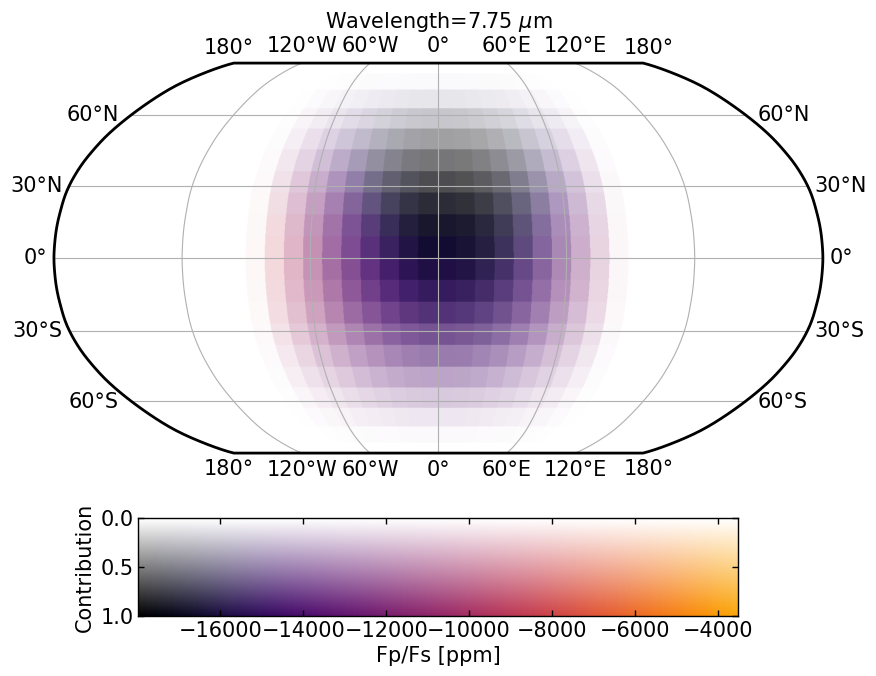

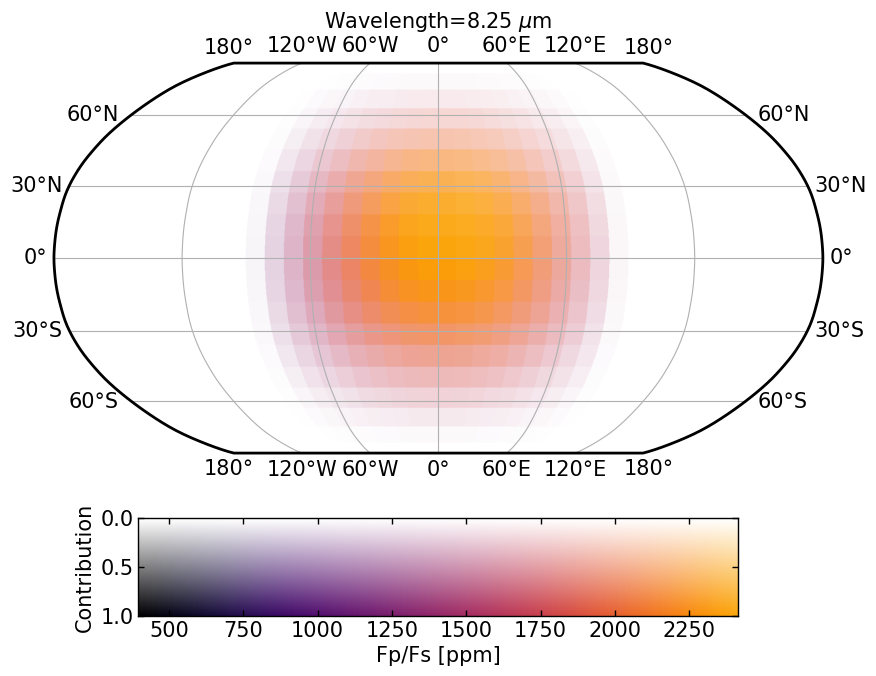

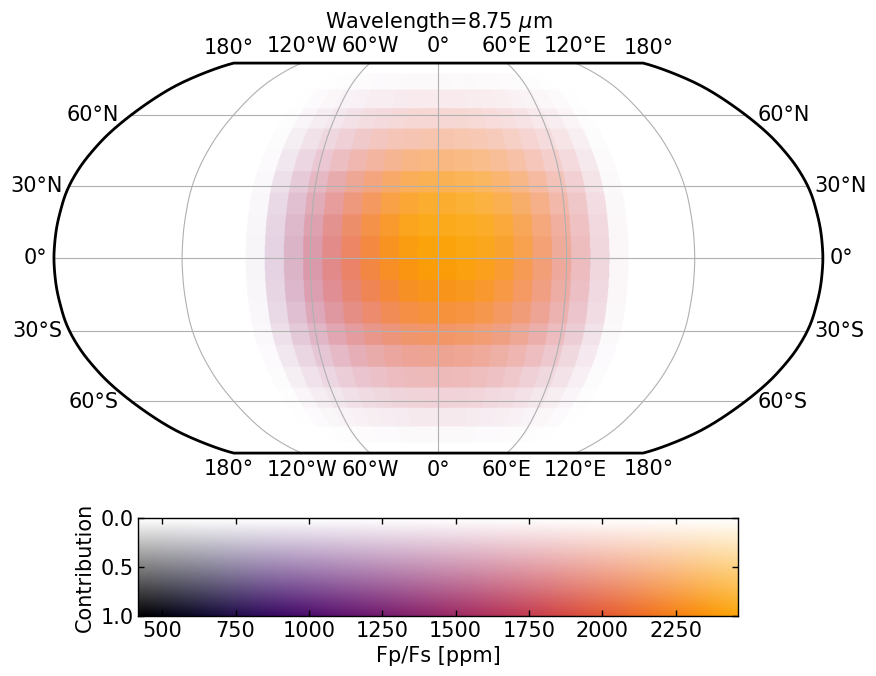

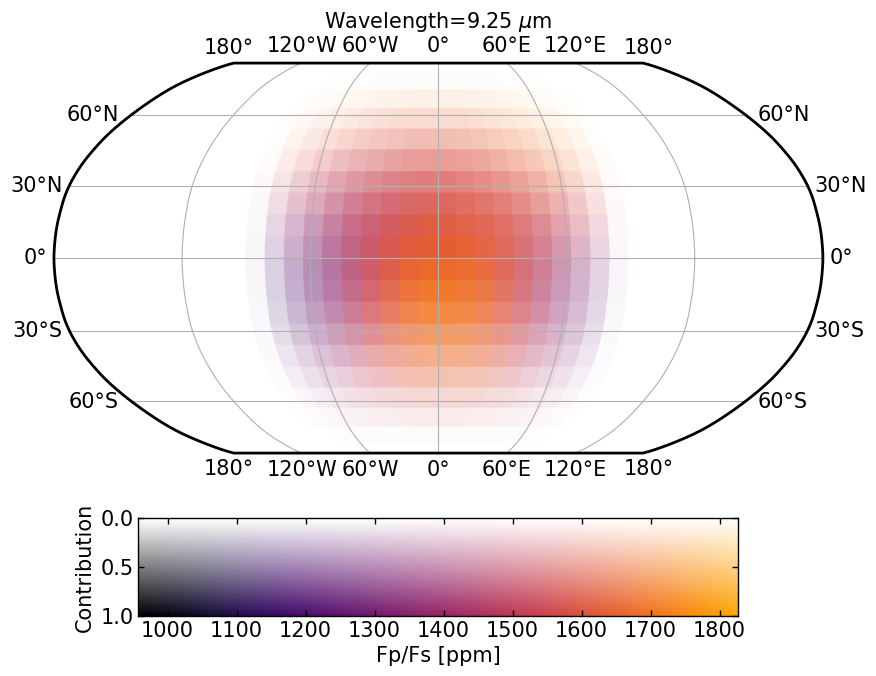

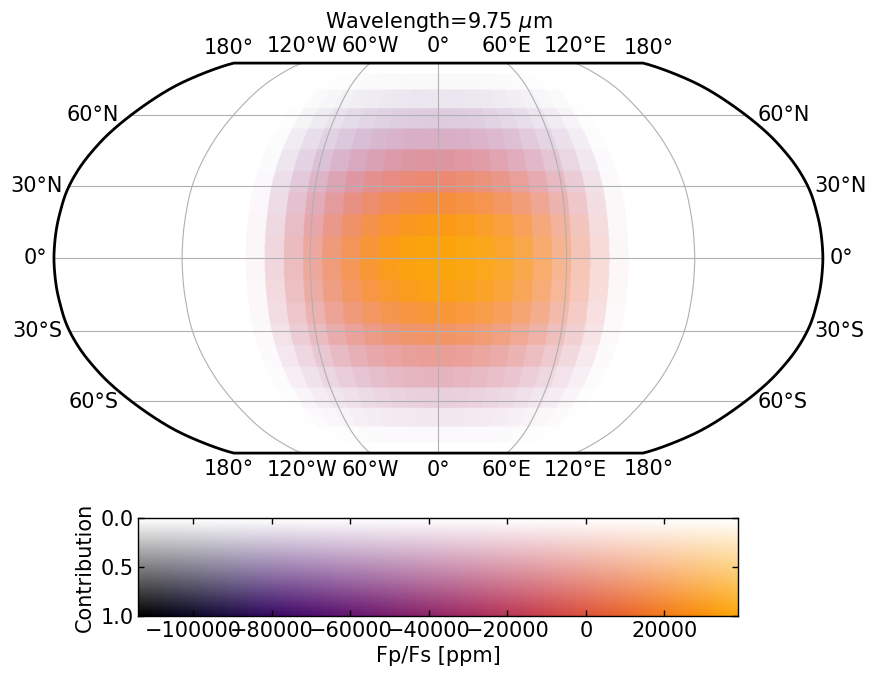

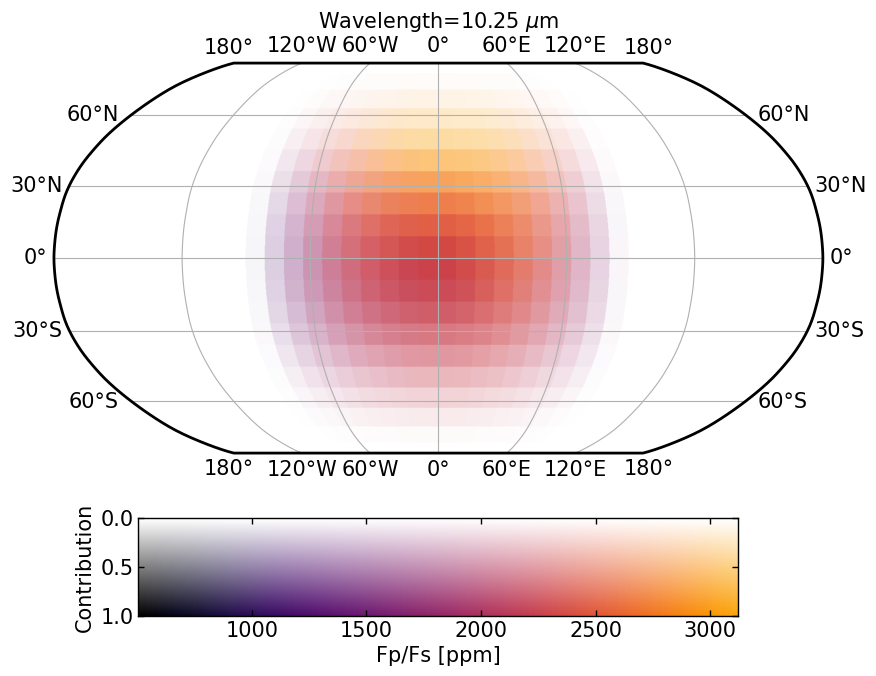

In [17]:
savedir=homedir+'/data/normalized_maps/W43_spectroscopic_phasecurve/flux_maps/'
ngroups=3
numsamp=500
plot_utils.do_hue_maps(savedir,numsamp,ngroups,hueType='flux')

